# Clustering of countries by wheat production

## Table of Contents
1. [Data ingestion](#Data-ingestion)
2. [Data preprocessing](#Data-preprocessing)
3. [EDA](#EDA)
4. [Model Training](#Model-Training)
5. [Model Testing](#Model-Testing)

## Data ingestion

### Introduction

The purpose behind creating this model comes from the perspective of a farmer. If you were a prospective farmer in a given country (for this case, Afghanistan), and you had space to produce at most 5 different crops at a time, what crops should you produce?

Our model solves this problem through clustering. Our dataset contains the consumption of various crops per 1000 tonnes for a variety of countries, and our model classifies these crops into clusters that will show the farmer exactly which crops he should prioritize for greater sales. 

Thanks to Dor Oppenheim for the [dataset](https://www.kaggle.com/dorbicycle/world-foodfeed-production)!

### Understanding the data 

We're given a series of columns, what's the meaning behind each one?

__Area Abbreviation, Area Code, Area__ - all correspond to the country  
__Item Code__ - Unique ID corresponding to the type of food  
__Item__ - Name of food (eg. wheat and products)  
__Element Code__ - Food or Feed, based on whether food was consumed by animals or humans  
__Unit__ - Measurement unit, for this case the data is all in 1000 tonnes units  
__latitude, longitude__ - Coordinates of country  
__Y1961, Y1962... etc__ - Consumption of a given crop in said year (eg. 1961 Wheat consumption per 1000 tonnes in USA)  

Wow, this is a lot of information. Some of this is useful to our farmer, but our farmer is living in 2019, so he has almost no use for data pre-2010s. We will be exploring and trimming this dataset extensively in the next section.

## Data preprocessing

__What columns should we keep for this dataset?__

For my use case, I removed all countries except Afghanistan and all years except from 2010-2013. Using the resulting dataframe, we can then perform clustering on the dataset. 

Let's begin by importing the _FAO.csv_ file.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('FAO.csv', encoding='latin-1')
print(df.head())

  Area Abbreviation  Area Code         Area  Item Code  \
0               AFG          2  Afghanistan       2511   
1               AFG          2  Afghanistan       2805   
2               AFG          2  Afghanistan       2513   
3               AFG          2  Afghanistan       2513   
4               AFG          2  Afghanistan       2514   

                       Item  Element Code Element         Unit  latitude  \
0        Wheat and products          5142    Food  1000 tonnes     33.94   
1  Rice (Milled Equivalent)          5142    Food  1000 tonnes     33.94   
2       Barley and products          5521    Feed  1000 tonnes     33.94   
3       Barley and products          5142    Food  1000 tonnes     33.94   
4        Maize and products          5521    Feed  1000 tonnes     33.94   

   longitude  ...     Y2004   Y2005   Y2006   Y2007   Y2008   Y2009   Y2010  \
0      67.71  ...    3249.0  3486.0  3704.0  4164.0  4252.0  4538.0  4605.0   
1      67.71  ...     419.0   445.0 

Many of these columns are useless for our case. Therefore, our next step will be to drop them to increase performance and reduce confusion.

In [2]:
df = df.drop(df.columns[10:51], axis = 1)
print(df.head())

  Area Abbreviation  Area Code         Area  Item Code  \
0               AFG          2  Afghanistan       2511   
1               AFG          2  Afghanistan       2805   
2               AFG          2  Afghanistan       2513   
3               AFG          2  Afghanistan       2513   
4               AFG          2  Afghanistan       2514   

                       Item  Element Code Element         Unit  latitude  \
0        Wheat and products          5142    Food  1000 tonnes     33.94   
1  Rice (Milled Equivalent)          5142    Food  1000 tonnes     33.94   
2       Barley and products          5521    Feed  1000 tonnes     33.94   
3       Barley and products          5142    Food  1000 tonnes     33.94   
4        Maize and products          5521    Feed  1000 tonnes     33.94   

   longitude  ...     Y2004   Y2005   Y2006   Y2007   Y2008   Y2009   Y2010  \
0      67.71  ...    3249.0  3486.0  3704.0  4164.0  4252.0  4538.0  4605.0   
1      67.71  ...     419.0   445.0 

We want to drop some extra columns that we still don't need, but we also want to add a new column to represent the three year weighted growth in crop production. 

In [3]:
df['3 Yr Growth'] = (df['Y2013'] - df['Y2010']) / 3.0
print(df.head())

  Area Abbreviation  Area Code         Area  Item Code  \
0               AFG          2  Afghanistan       2511   
1               AFG          2  Afghanistan       2805   
2               AFG          2  Afghanistan       2513   
3               AFG          2  Afghanistan       2513   
4               AFG          2  Afghanistan       2514   

                       Item  Element Code Element         Unit  latitude  \
0        Wheat and products          5142    Food  1000 tonnes     33.94   
1  Rice (Milled Equivalent)          5142    Food  1000 tonnes     33.94   
2       Barley and products          5521    Feed  1000 tonnes     33.94   
3       Barley and products          5142    Food  1000 tonnes     33.94   
4        Maize and products          5521    Feed  1000 tonnes     33.94   

   longitude     ...        Y2005   Y2006   Y2007   Y2008   Y2009   Y2010  \
0      67.71     ...       3486.0  3704.0  4164.0  4252.0  4538.0  4605.0   
1      67.71     ...        445.0   546.

In [4]:
unwanted_features = ['Area Code', 'Item Code', 'Element Code', 'Unit', 'latitude', 'longitude', 'Area Abbreviation']
for item in unwanted_features:
    df.drop(item, axis = 1, inplace= True)
print(df.head())

          Area                      Item Element   Y2002   Y2003   Y2004  \
0  Afghanistan        Wheat and products    Food  2776.0  3095.0  3249.0   
1  Afghanistan  Rice (Milled Equivalent)    Food   448.0   460.0   419.0   
2  Afghanistan       Barley and products    Feed    70.0    48.0    58.0   
3  Afghanistan       Barley and products    Food   122.0   144.0   185.0   
4  Afghanistan        Maize and products    Feed    89.0    63.0   120.0   

    Y2005   Y2006   Y2007   Y2008   Y2009   Y2010   Y2011  Y2012  Y2013  \
0  3486.0  3704.0  4164.0  4252.0  4538.0  4605.0  4711.0   4810   4895   
1   445.0   546.0   455.0   490.0   415.0   442.0   476.0    425    422   
2   236.0   262.0   263.0   230.0   379.0   315.0   203.0    367    360   
3    43.0    44.0    48.0    62.0    55.0    60.0    72.0     78     89   
4   208.0   233.0   249.0   247.0   195.0   178.0   191.0    200    200   

   3 Yr Growth  
0    96.666667  
1    -6.666667  
2    15.000000  
3     9.666667  
4     7

I created the 3 Yr Growth column to better illustrate the trends for what crop to select. Since crop production isn't instantaneous, I chose 3 years to give a better picture of the demand over time. 

We've now removed all of the unnecessary columns from the dataset, so we can begin preprocessing the data. First, we need to check for the presence of any null values that could affect our model. 

In [5]:
print("Presence of null values: " + str(df.isnull().values.any()))
print("Percentage of NaN/null values: " + str(df.isnull().sum()/len(df)*100))

Presence of null values: True
Percentage of NaN/null values: Area           0.000000
Item           0.000000
Element        0.000000
Y2002          1.624994
Y2003          1.624994
Y2004          1.624994
Y2005          1.624994
Y2006          0.484239
Y2007          0.484239
Y2008          0.484239
Y2009          0.484239
Y2010          0.484239
Y2011          0.484239
Y2012          0.000000
Y2013          0.000000
3 Yr Growth    0.484239
dtype: float64


Looks like we will have to fill in values for these columns of the dataset. Looking at the FAO.csv, we see these null values are usually for entire countries that have no data present. Therefore, it should be okay to fill these values in with 0 since these countries were not producing any of the product at the time. We can also encode some of our categorical features using LabelEncoder to give us numerical values. 

In [6]:
from sklearn.preprocessing import LabelEncoder

df = df.fillna(0)
lbl = LabelEncoder()
col_names = df.columns
for name in col_names:
    lbl.fit(df[name])
    df[name] = lbl.transform(df[name])

We can now separate our data into food and feed columns using the 'Element' column name, and select the food data for wheat (item code 112).

In [7]:
food_df = df.loc[df['Element'] == 1]
feed_df = df.loc[df['Element'] == 0]

new_df = food_df.loc[df['Item'] == 112]
print(new_df.head())

     Area  Item  Element  Y2002  Y2003  Y2004  Y2005  Y2006  Y2007  Y2008  \
0       0   112        1   1401   1450   1472   1519   1554   1594   1625   
84      1   112        1    524    474    445    463    420    423    430   
207     2   112        1   1649   1691   1692   1703   1713   1717   1755   
330     3   112        1    360    413    470    511    557    587    613   
439     4   112        1      5      5      5      5      5      5      5   

     Y2009  Y2010  Y2011  Y2012  Y2013  3 Yr Growth  
0     1653   1671   1695   1714   1734          642  
84     411    429    433    436    441          376  
207   1781   1784   1822   1833   1849          803  
330    622    653    718    757    792          548  
439      5      6      5      6      7          368  


After processing all of the given data, we can now begin the clustering algorithm for our dataset, using KMeans clustering and the silhouette value to calculate the optimal k value.

## EDA

Let's plot the correlation map of the dataset, to see if there's any features that are really highly correlated. 

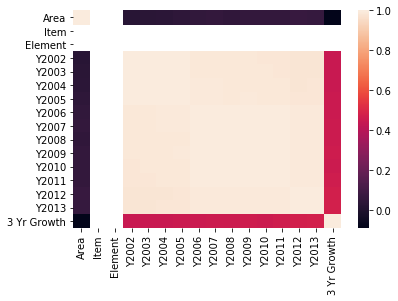

In [9]:
import seaborn as sns

corr = new_df.corr()
sns.heatmap(corr)

The correlation map isn't much help here, as expected. Let's see if a bar graph can give us any insight into our data. However, we have to plot a subset of our dataframe, as 173 countries would give a useless graph. 

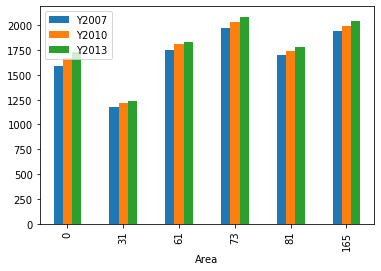

In [10]:
subset_df = new_df.query('Area == 0 or Area == 31 or Area == 61 or Area == 73 or Area == 81 or Area == 165')
subset_df.plot(x="Area", y=["Y2007", "Y2010", "Y2013"], kind="bar")

The above values correspond to the following countries:  
__Afghanistan__ = 0  
__Chile__ = 31  
__Germany__ = 61  
__India__ = 73  
__Japan__ = 81  
__USA__ = 165  

Here we can see that the clustering has already started to reveal itself. India and the USA are very close in the top producers of wheat, while Afghanistan, Germany, and Japan are close behind. Chile is a tier below, showing that we can identify around 3 clusters forming already. 

## Model Training

Now that we've seen the clustering firsthand, we can use our developed automated KMeans clustering algorithm to get an optimal clustering for the above data. We have two different methods we can use for calculating the optimal clusters automatically: the silhouette method and the elbow method.

The silhouette method gives a more accurate optimal K value, but at a O(N^2) runtime, meaning that we would have to trim our dataset to use it. The elbow method computes the optimal K much faster, but there is a higher chance that it outputs an incorrect K value compared to the silhouette. 

Let's start with the elbow method, and the plotting of the elbow method. 

In [11]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
import math

error = []
for i in range(1, int(math.sqrt(len(new_df)))):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(new_df)
    error.append(kmeans.inertia_)
    
optimalK = KneeLocator(
    range(1, int(math.sqrt(len(new_df)))),
    error,
    curve = 'convex',
    direction = 'decreasing',
    interp_method = 'interp1d',
)

The KneeLocator object has a parameter elbow, which will give the optimal K value for the K Means algorithm. 

In [12]:
print(optimalK.elbow)

3


Note that this value has a certain error, due to the fact that I reduced the computation time to be the sqrt of the number of rows in the dataframe. This is done to save time and maximize accuracy versus time spent computing. 

Let's try the silhouette method below:

In [13]:
from sklearn.metrics import silhouette_score

silhouette_vals = dict()
for i in range(2, 10):
    kmeans = KMeans(n_clusters = i)
    cluster_labels = kmeans.fit_predict(new_df)
    silhouette_vals[i] = silhouette_score(new_df, cluster_labels)


The silhouette method computes the distance of every data point to the cluster nodes and adjusts the center position until each cluster center is far enough away to produce an optimal cluster center for all other data points. The maximum silhouette score will give us needed optimal K value. Read more about the silhouette method [here](https://en.wikipedia.org/wiki/Silhouette_(clustering)).

In [14]:
optimalK_silhouette = max(silhouette_vals, key=silhouette_vals.get)
print(optimalK_silhouette)

2


Again, due to the inaccuracies when automating the K selection, there may be differing values between the two methods. Here is one such example. A good approach would be to compute both and see which K value suits the dataset according to your standards. 

## Model Testing

Let's plot the clustering done by the KMeans elbow method:

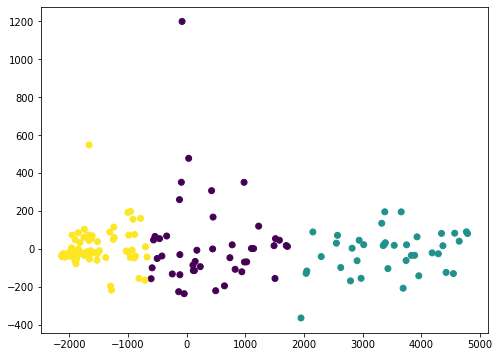

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = optimalK.elbow)
wheat_df = pca.fit_transform(new_df)
model = KMeans(n_clusters = optimalK.elbow).fit(wheat_df)
plt.figure(figsize=(8, 6))
plt.scatter(wheat_df[:,0], wheat_df[:,1], c=model.labels_.astype(float))

The elbow method gives us a fairly good clustering of the datapoints, showing that there are distinct clusters of countries with high wheat production throughout the world. Since we are using PCA, a lot of the information is obfuscated. However, we can at least see that the clustering algorithm produces a reasonable result. 

Let's now plot the clustering given by the silhouette method:

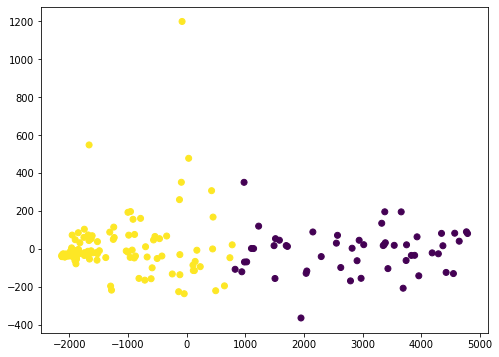

In [16]:
pca = PCA(n_components = 2)
silhouette_df = pca.fit_transform(new_df)

model = KMeans(n_clusters = optimalK_silhouette).fit(new_df)
plt.figure(figsize=(8, 6))
plt.scatter(silhouette_df[:,0], silhouette_df[:,1], c=model.labels_.astype(float))


The silhouette method gives us another clustering, which also looks reasonable for the dataset. From here, the best way to choose the preferred K value is through personal preference. I chose the elbow method value because I thought the 3-clustering was more reasonable than the 2-clustering given by the silhouette. 

From here, the farmer can clearly make a decision about where to sell wheat. Based on the clustering given above, the farmer will most likely sell the most product on the upper-right most data points. From there, he can choose which countries he decides to sell to, solving his original problem. 